In [1]:
import os
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException



# Directory to save the downloaded files
download_dir = "/home/disk1/finance_quant/efinance/downloaded_files"
os.makedirs(download_dir, exist_ok=True)

# Initialize ChromeDriver
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Enable logging
options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})

driver = webdriver.Chrome(options=options)

# Enable network interception
driver.execute_cdp_cmd('Network.enable', {})


{}

driver.get_page

Found element with class tab and text United States
Found element with class tab and text Sector
Error getting response body for https://api.lbkrs.com/market/concept_stocks?concept_index=BK%2FHK%2FIN20263&indicator=1&limit=1&offset=0&order=0&tab_key=0&filter_tag_key=3: Message: unknown error: unhandled inspector error: {"code":-32000,"message":"No resource with given identifier found"}
  (Session info: chrome-headless-shell=126.0.6478.126)
Stacktrace:
#0 0x561e5bec4c7a <unknown>
#1 0x561e5bba7e2c <unknown>
#2 0x561e5bb8e446 <unknown>
#3 0x561e5bb8cb48 <unknown>
#4 0x561e5bb8d33f <unknown>
#5 0x561e5bb8d294 <unknown>
#6 0x561e5bbaae4f <unknown>
#7 0x561e5bc4346a <unknown>
#8 0x561e5bc175c2 <unknown>
#9 0x561e5bc36303 <unknown>
#10 0x561e5bc17363 <unknown>
#11 0x561e5bbe7247 <unknown>
#12 0x561e5bbe7b9e <unknown>
#13 0x561e5be8b24b <unknown>
#14 0x561e5be8f2f1 <unknown>
#15 0x561e5be76afe <unknown>
#16 0x561e5be8fe52 <unknown>
#17 0x561e5be5b79f <unknown>
#18 0x561e5beb4638 <unknown>
#19
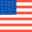
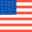

KeyboardInterrupt: 

In [3]:

# Function to save downloaded file (if applicable)
def save_file(url, content):
    filename = os.path.join(download_dir, url.split('/')[-1])
    with open(filename, 'wb') as f:
        f.write(content.encode('utf-8'))
    print(f"Downloaded {filename}")
    
def save_json(content):
  filename = os.path.join(download_dir, "data.json")
  with open(filename, "w") as outfile:
    json.dump(content, filename)

# Function to process performance logs
def process_browser_logs_for_network_events(logs):
    for entry in logs:
        log = json.loads(entry['message'])['message']
        if (
            'Network.responseReceived' in log['method']
            and 'params' in log
            and 'response' in log['params']
        ):
            response = log['params']['response']
            url = response['url']
            if any(url.endswith(ext) for ext in ['.js', '.css', '.json', '.svg']):
                try:
                    content = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': log['params']['requestId']})
                    save_file(url, content['body'])
                except Exception as e:
                    print(f"Error getting response body for {url}: {e}")
                    
# Function to process performance logs
def process_browser_logs_for_network_events_json(logs):
    target_url = "https://api.lbkrs.com/market/concept_stocks"
    
    for entry in logs:
        log = json.loads(entry['message'])['message']
        if (
            'Network.responseReceived' in log['method']
            and 'params' in log
            and 'response' in log['params']
        ):
            response = log['params']['response']
            url = response['url']
            if url.startswith(target_url):
                try:
                    content = driver.execute_cdp_cmd('Network.getResponseBody', {'requestId': log['params']['requestId']})
                    # save_json(json.loads(content['body']))
                    print(content['body'])
                    # return True  # Found and saved the target URL
                except Exception as e:
                    print(f"Error getting response body for {url}: {e}")
    
    return False  # Target URL not found

def find_element_by_class_and_text(driver, class_name, main_page_text, sub_page_text=None):
    """
    This function finds an element with a specific class name and text content.

    Args:
        driver: The WebDriver instance.
        class_name: The class name of the element to search for.
        main_page_text: The primary text content to search for.
        sub_page_text (optional): An additional text content to search for (defaults to None).

    Returns:
        The WebElement if found, otherwise None.
    """
    main_element = None
    sub_element = None
    
    try:
        elements = driver.find_elements(By.CLASS_NAME, class_name)
        for element in elements:
            if element.text == main_page_text:
                print(f"Found element with class {class_name} and text {main_page_text}")
                WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, class_name)))
                try:
                    element.click()
                except ElementClickInterceptedException:
                    driver.execute_script("arguments[0].scrollIntoView();", element)
                    driver.execute_script("arguments[0].click();", element)
                main_element = element
                break  # Exit after finding and clicking the main text
        
        if sub_page_text:
            elements = driver.find_elements(By.CLASS_NAME, class_name)
            for element in elements:
                if element.text == sub_page_text:
                    print(f"Found element with class {class_name} and text {sub_page_text}")
                    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, class_name)))
                    try:
                        element.click()
                    except ElementClickInterceptedException:
                        driver.execute_script("arguments[0].scrollIntoView();", element)
                        driver.execute_script("arguments[0].click();", element)
                    sub_element = element
                    break  # Exit after finding and clicking the sub text (if provided)
    
    except TimeoutException:
        print(f"Timeout waiting for element with class {class_name}")
    
    if main_element and (sub_page_text is None or sub_element):
        return main_element, sub_element
    else:
        print(f"Element with class {class_name}, main_page_text '{main_page_text}', sub_page_text '{sub_page_text}' not found")
        return None

# Example usage:
# driver = webdriver.Chrome()
# driver.get("https://example.com")
# find_element_by_class_and_text(driver, "example-class", "Main Page Text", "Sub Page Text")
# driver.quit()


# ... (rest of your code)

try:

    # Open a webpage
    driver.get("https://longportapp.com/en/markets/")

    # Wait for page to load (adjust wait time and selector as needed)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "portal")))
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "tabs")))
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "tab")))
    # WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "United States")))
    # WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "Sector")))

    # XPath expression to target the child element with the symbol

    # find_element_by_class_and_text(driver, "tab", "Hong Kong",  "Sector")
    find_element_by_class_and_text(driver, "tab", "United States", "Sector")

    # Retrieve and process performance logs
    logs = driver.get_log('performance')
    process_browser_logs_for_network_events_json(logs)

finally:
    print(logs)
    
#     # Quit the driver
#     driver.quit()
